# Imports

In [7]:
from pprint import pprint
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder
from ta_lib.eda.analysis import get_frequency_plots
from ta_lib.eda.analysis import get_bivariate_plots
from ta_lib.eda.analysis import get_target_correlation
from ta_lib.eda.analysis import get_correlation_table
%matplotlib inline

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.", 
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)

In [10]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset,list_datasets, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [11]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)
pprint(list_datasets(context))

googlesearch_df = load_dataset(context,'/cleaned/googlesearch')
manufacturerlist_df = load_dataset(context,'/cleaned/manufacturerlist')
sales_df = load_dataset(context,'/cleaned/sales')
socialmedia_df = load_dataset(context,'/cleaned/socialmedia')
theme_df = load_dataset(context,'/cleaned/theme')
themeproduct_df = load_dataset(context,'/cleaned/themeproduct')
sales_processed_df = load_dataset(context,'/processed/sales')

['/raw/googlesearch',
 '/raw/manufacturerlist',
 '/raw/sales',
 '/raw/socialmedia',
 '/raw/theme',
 '/raw/themeproduct',
 '/cleaned/googlesearch',
 '/cleaned/manufacturerlist',
 '/cleaned/sales',
 '/cleaned/socialmedia',
 '/cleaned/theme',
 '/cleaned/themeproduct',
 '/cleaned/merged_data',
 '/cleaned/social_google_sales_data',
 '/processed/sales',
 '/train/sales/features',
 '/train/sales/target',
 '/test/sales/features',
 '/test/sales/target']


# Feature Analysis

### ●	Provide the list of themes available across all data sources

- google_search
- sales_df
- social_media

- social_google_sales_data contains google_search,sales_df,social_media alongwith theme data. Let's use this data for our analysis

In [12]:
merged_df2 = load_dataset(context,'/cleaned/social_google_sales_data')

In [13]:
merged_df2.head()

,date,platform,search_volume,claim_id,week_number,year_new,total_post,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,claim_name
0,2016-10-01,google,7630,8,39,2016,385,23402,37491,19322,6642,low carb
1,2016-10-01,google,7630,8,39,2016,385,23403,31197,16425,5646,low carb
2,2016-10-01,google,7630,8,39,2016,385,23404,57312,31024,10664,low carb
3,2016-10-01,google,7630,8,39,2016,385,23405,22530,11942,4105,low carb
4,2016-10-01,google,7630,8,39,2016,385,23406,75569,39883,13710,low carb


In [14]:
merged_df2['claim_name'].unique()

array(['low carb', 'high/source of protein', 'low calorie', 'low sodium',
       'bone health', 'prebiotic', 'ethical - packaging', 'low sugar',
       'energy/alertness', 'soy foods', 'gmo free',
       'convenience - easy-to-prepare', 'vegetarian', 'poultry',
       'ethnic & exotic', 'blueberry', 'chicken', 'french bisque',
       'salmon', 'beef hamburger', 'crab', 'no additives/preservatives',
       'mackerel', 'peach', 'tuna', 'ethical - not specific', 'halal',
       'gingerbread'], dtype=object)

In [15]:
get_frequency_plots(merged_df2,cols=['claim_name'])

:Layout
   .Bars.Claim_name :Bars   [index]   (claim_name)
   .Table.I         :Table   [count,unique,top,freq]

### ●	Understands consumer preference(themes) available in each data source

**Consumer preference in google search data**

In [16]:
googlesearch_df_clean = load_dataset(context,'/cleaned/googlesearch')
manufacturerlist_df_clean = load_dataset(context,'/cleaned/manufacturerlist')
sales_df_clean = load_dataset(context,'/cleaned/sales')
socialmedia_df_clean = load_dataset(context,'/cleaned/socialmedia')
theme_df_clean = load_dataset(context,'/cleaned/theme')
themeproduct_df_clean = load_dataset(context,'/cleaned/themeproduct')

In [17]:
gsearch_theme = pd.merge(googlesearch_df_clean,theme_df_clean,how='inner',on=['claim_id'])
gsearch_theme.head()

,date,platform,search_volume,claim_id,week_number,year_new,month,day,quarter,claim_name
0,2014-01-05,google,349,916,1,2014,January,5,1,gluten free
1,2014-01-06,google,349,916,2,2014,January,6,1,gluten free
2,2014-01-07,google,697,916,2,2014,January,7,1,gluten free
3,2014-01-10,google,349,916,2,2014,January,10,1,gluten free
4,2014-01-20,google,697,916,4,2014,January,20,1,gluten free


In [18]:
len(gsearch_theme['claim_name'].unique())

160

In [19]:
get_frequency_plots(gsearch_theme,cols=['claim_name'])

:Layout
   .Bars.Claim_name :Bars   [index]   (claim_name)
   .Table.I         :Table   [count,unique,top,freq]

**Consumer preference in sales_df**

In [20]:
sales_theme_prod = pd.merge(sales_df_clean,themeproduct_df_clean,how='inner',on=['product_id'])
sales_theme_prod.head()

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,month,day,quarter,year,claim_id
0,2016-01-09,1,13927,934,18680,January,9,1,2016,0
1,2016-01-23,1,12628,878,17564,January,23,1,2016,0
2,2016-02-06,1,11379,810,16200,February,6,1,2016,0
3,2016-01-30,1,11568,821,16424,January,30,1,2016,0
4,2016-02-13,1,10959,784,15682,February,13,1,2016,0


In [21]:
sales_theme = pd.merge(sales_theme_prod,theme_df_clean,how='inner',on=['claim_id'])
sales_theme.head()

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,month,day,quarter,year,claim_id,claim_name
0,2016-01-09,1,13927,934,18680,January,9,1,2016,0,No Claim
1,2016-01-23,1,12628,878,17564,January,23,1,2016,0,No Claim
2,2016-02-06,1,11379,810,16200,February,6,1,2016,0,No Claim
3,2016-01-30,1,11568,821,16424,January,30,1,2016,0,No Claim
4,2016-02-13,1,10959,784,15682,February,13,1,2016,0,No Claim


In [22]:
len(sales_theme['claim_name'].unique())

49

In [23]:
get_frequency_plots(sales_theme,cols=['claim_name'])

:Layout
   .Bars.Claim_name :Bars   [index]   (claim_name)
   .Table.I         :Table   [count,unique,top,freq]

**Consumer preference in social media data**

In [24]:
social_media_theme = pd.merge(socialmedia_df_clean,theme_df_clean,how='inner',on=['claim_id'])
social_media_theme.head()

,claim_id,date,total_post,month,day,quarter,year,claim_name
0,148,2015-10-01,76,October,1,4,2015,tuna
1,148,2015-10-10,31,October,10,4,2015,tuna
2,148,2015-10-11,65,October,11,4,2015,tuna
3,148,2015-10-12,88,October,12,4,2015,tuna
4,148,2015-10-13,85,October,13,4,2015,tuna


In [25]:
len(social_media_theme['claim_name'].unique())

194

In [26]:
get_frequency_plots(social_media_theme,cols=['claim_name'])

:Layout
   .Bars.Claim_name :Bars   [index]   (claim_name)
   .Table.I         :Table   [count,unique,top,freq]

Observation:
- According to google search data, there are a total of 160 themes for the consumers, with seasonal/in-out products being preferred the most followed by health (passive) and boar.
- According to sales data, there are just 49 themes preferred by the consumers, with low carb preferred the most followed by no additives/preservatives and apple cinnamon. There are a lot of unclaimed themes too having the highest occurrence in the data .
- According to social media data, there are a total of 194 themes for the consumers, with seasonal/in-out products being preferred the most followed by co-branding and vegetarian. The unclaimed theme here too tops the list by having the most number of occurrences.

### ●	Recommend the time granularity (Daily/Weekly/Monthly/Quarterly/Yearly) for the analysis

In [27]:
merged_df2.head()

,date,platform,search_volume,claim_id,week_number,year_new,total_post,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,claim_name
0,2016-10-01,google,7630,8,39,2016,385,23402,37491,19322,6642,low carb
1,2016-10-01,google,7630,8,39,2016,385,23403,31197,16425,5646,low carb
2,2016-10-01,google,7630,8,39,2016,385,23404,57312,31024,10664,low carb
3,2016-10-01,google,7630,8,39,2016,385,23405,22530,11942,4105,low carb
4,2016-10-01,google,7630,8,39,2016,385,23406,75569,39883,13710,low carb


In [28]:
merged_df2['month'] = merged_df2['date'].dt.month_name()
merged_df2['weekday'] = merged_df2['date'].dt.day_name()

In [29]:
merged_df2.head()

,date,platform,search_volume,claim_id,week_number,year_new,total_post,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,claim_name,month,weekday
0,2016-10-01,google,7630,8,39,2016,385,23402,37491,19322,6642,low carb,October,Saturday
1,2016-10-01,google,7630,8,39,2016,385,23403,31197,16425,5646,low carb,October,Saturday
2,2016-10-01,google,7630,8,39,2016,385,23404,57312,31024,10664,low carb,October,Saturday
3,2016-10-01,google,7630,8,39,2016,385,23405,22530,11942,4105,low carb,October,Saturday
4,2016-10-01,google,7630,8,39,2016,385,23406,75569,39883,13710,low carb,October,Saturday


In [30]:
merged_df2.weekday.value_counts()

Saturday    5536320
Name: weekday, dtype: int64

In [31]:
sales = merged_df2
sales['date'] = pd.to_datetime(sales['date'],errors='coerce')
sales = sales.set_index('date')

Text(0, 0.5, 'monthly sales')

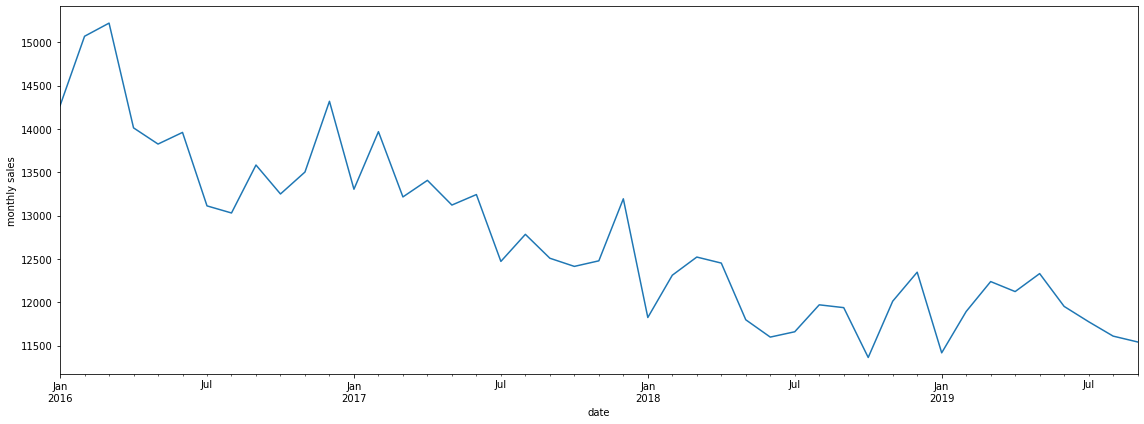

In [32]:
sales['sales_dollars_value'].resample('M').mean().plot(figsize=(16,6))
plt.ylabel('monthly sales')

Text(0, 0.5, 'weekly sales')

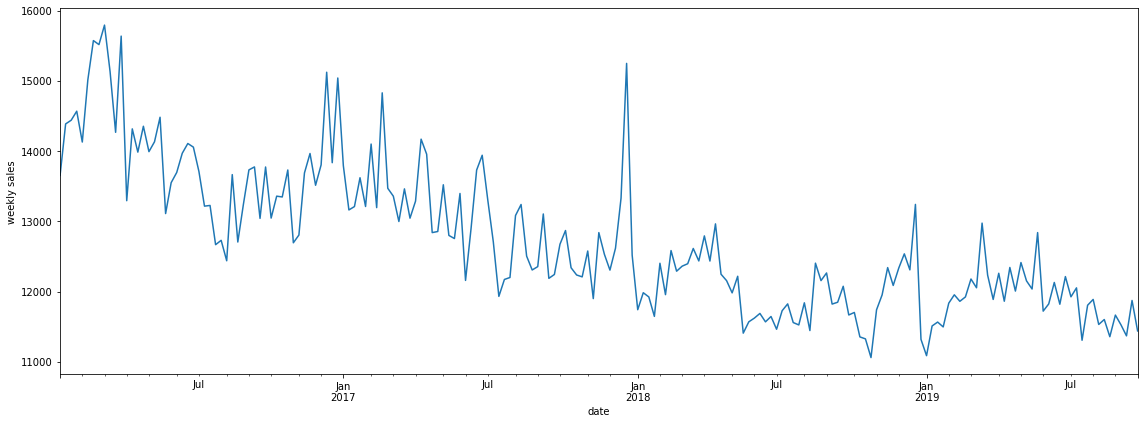

In [33]:
sales['sales_dollars_value'].resample('W').mean().plot.line(figsize=(16,6))
plt.ylabel('weekly sales')

Text(0, 0.5, 'yearly sales')

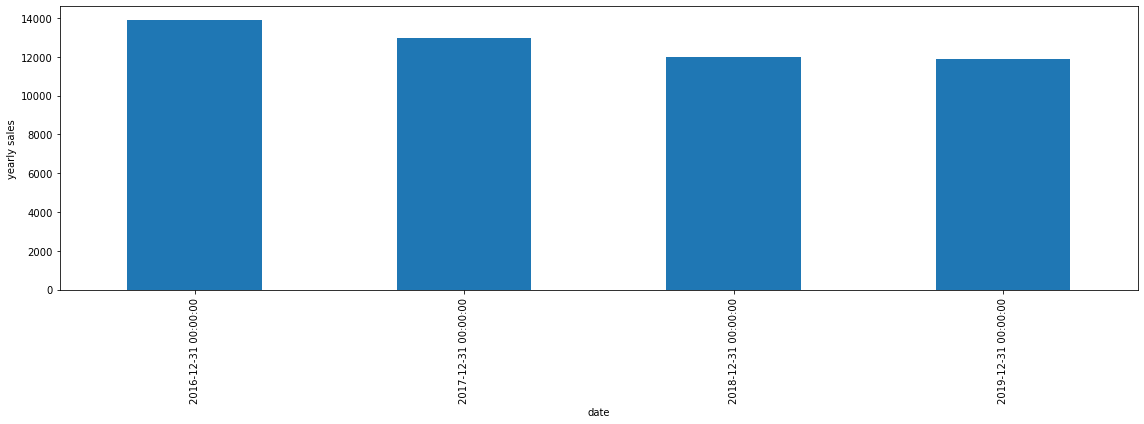

In [34]:
sales['sales_dollars_value'].resample('Y').mean().plot.bar(figsize=(16,6))
plt.ylabel('yearly sales')

Text(0, 0.5, 'quaterly sales')

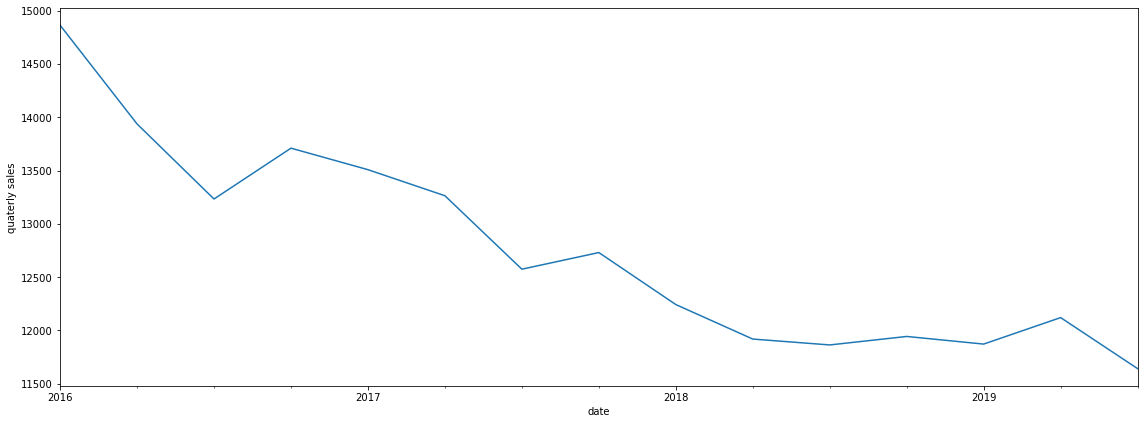

In [35]:
sales['sales_dollars_value'].resample('Q').mean().plot(figsize=(16,6))
plt.ylabel('quaterly sales')

Text(0, 0.5, 'daily sales')

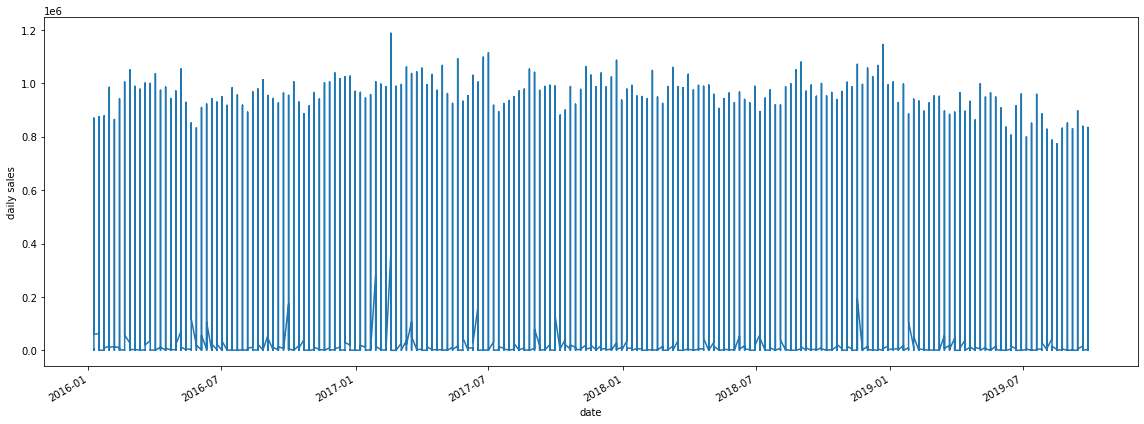

In [36]:
sales['sales_dollars_value'].plot.line(figsize=(16,6))
plt.ylabel('daily sales')

Observation:
- There is some seasonality in the data monthly. As we can see the mean sales drop by the end of the year and rise up again in January. 


### ●	Merge the required data sources

In [37]:
#since we have already merged the required sources, let's load the same
merged_df_final = load_dataset(context,'/cleaned/merged_data')
merged_df_final.head()

,date,platform,search_volume,claim_id,week_number,year_new,total_post,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,claim_name,vendor,month,day,quarter
0,2016-10-01,google,7630,8,39,2016,385,23402,37491,19322,6642,low carb,Others,October,1,4
1,2016-10-08,google,4705,8,40,2016,193,23402,38456,20549,7064,low carb,Others,October,8,4
2,2016-10-15,google,5087,8,41,2016,184,23402,37060,19601,6737,low carb,Others,October,15,4
3,2016-10-22,google,6740,8,42,2016,228,23402,35755,19217,6606,low carb,Others,October,22,4
4,2016-10-29,google,4960,8,43,2016,183,23402,38487,20301,6978,low carb,Others,October,29,4


### ●	Understand the overall market share of our client

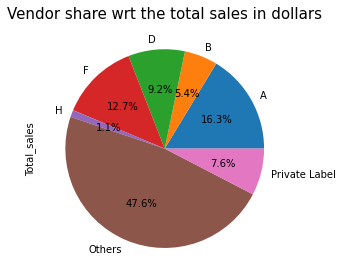

In [38]:
data = merged_df_final.groupby('vendor')['sales_dollars_value'].agg(Total_sales = ('sales_dollars_value', 'sum'))
data['Total_sales'].plot.pie(autopct='%1.1f%%')
plt.title('Vendor share wrt the total sales in dollars', fontsize=15)
plt.show()

- Our client has 16.3% market share wrt the total sales

### ●	Find the potential competitors for our client in each theme

In [39]:
merged_df_final['claim_name'].unique()

array(['low carb', 'no additives/preservatives', 'blueberry',
       'french bisque', 'salmon', 'chicken', 'crab', 'energy/alertness',
       'low sodium', 'low sugar', 'beef hamburger',
       'high/source of protein', 'gmo free', 'ethical - packaging',
       'ethnic & exotic', 'poultry', 'gingerbread', 'vegetarian',
       'prebiotic', 'soy foods', 'mackerel', 'low calorie',
       'convenience - easy-to-prepare', 'peach', 'bone health', 'halal',
       'ethical - not specific', 'tuna'], dtype=object)

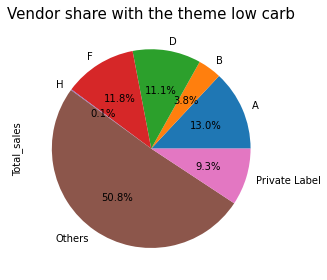

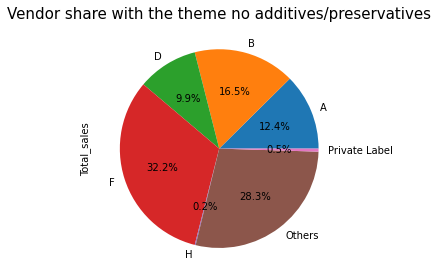

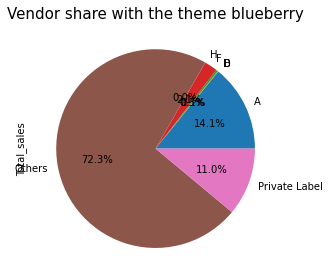

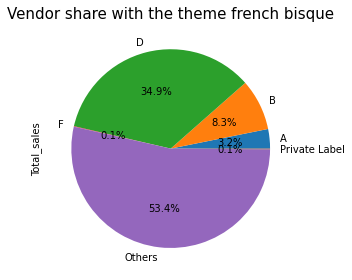

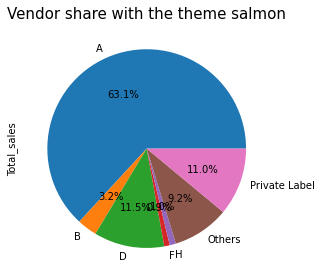

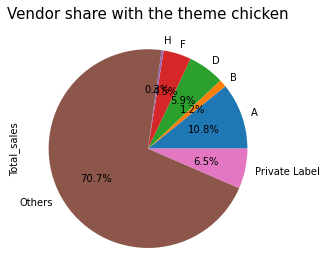

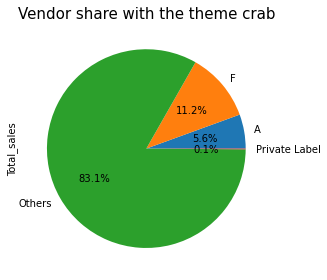

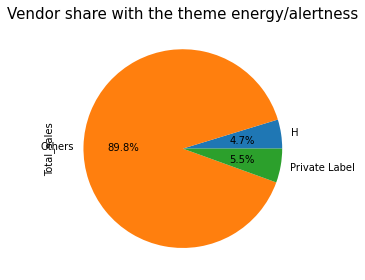

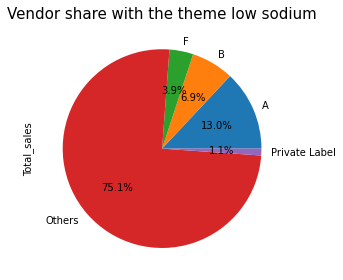

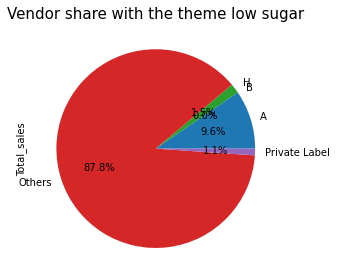

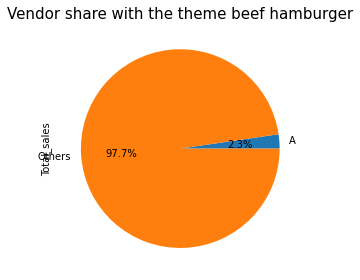

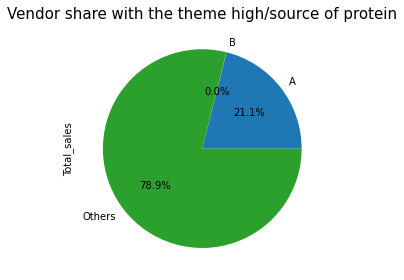

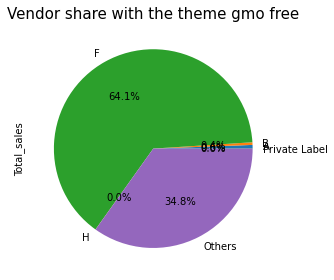

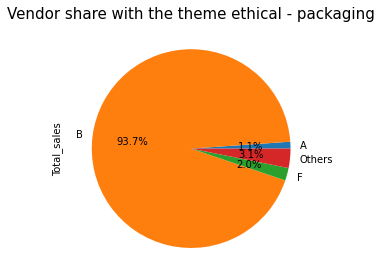

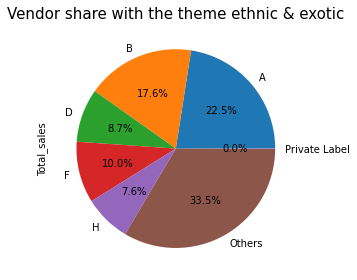

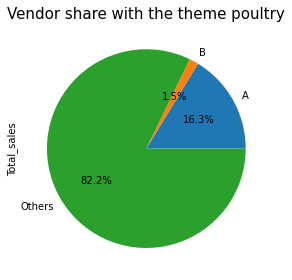

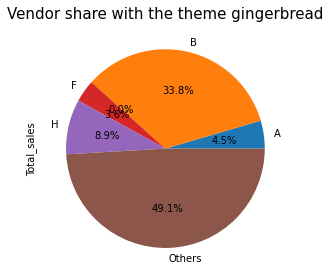

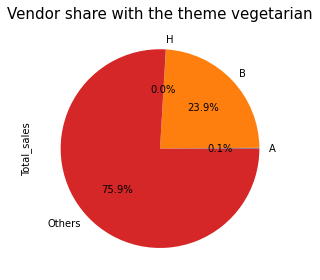

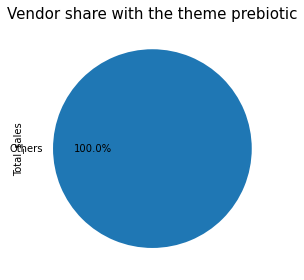

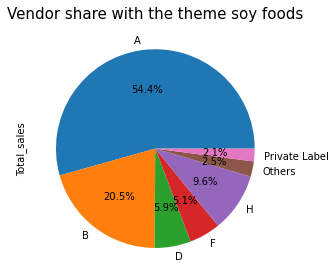

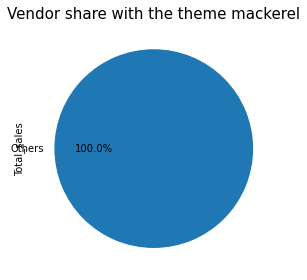

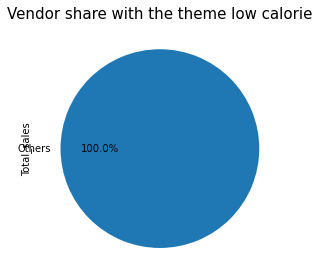

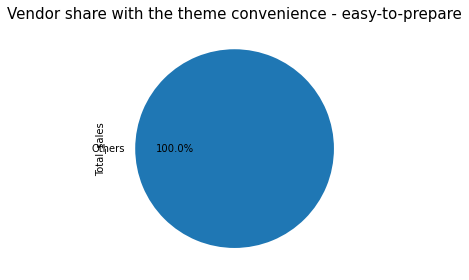

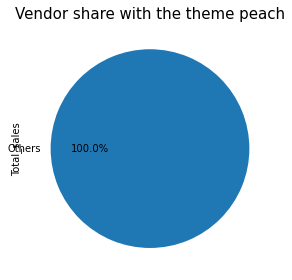

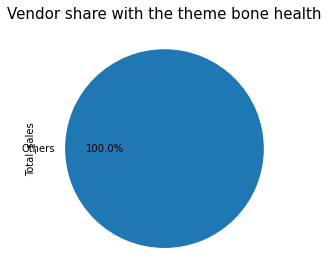

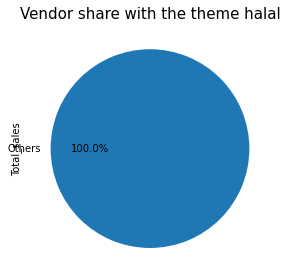

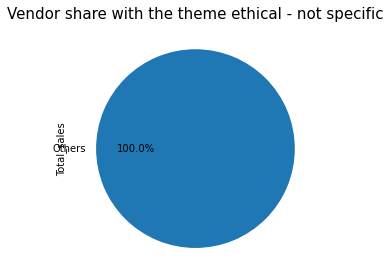

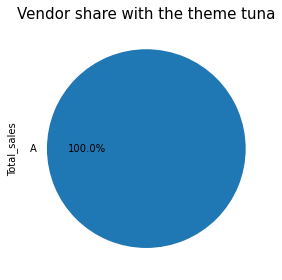

In [40]:
data=merged_df_final
#plotting share of the vendors for each theme 
for theme in data['claim_name'].unique():
    data=merged_df_final[merged_df_final['claim_name']==theme]
    data = data.groupby('vendor')['sales_dollars_value'].agg(Total_sales = ('sales_dollars_value', 'sum'))
    data['Total_sales'].plot.pie(autopct='%1.1f%%')
    plt.title('Vendor share with the theme {}'.format(theme), fontsize=15)
    plt.show()

### ●	What are the themes which are emerging in social media, Google Search & Sales?

**Google search emerging themes**

In [41]:
googlesearch_df_theme = pd.merge(googlesearch_df_clean,theme_df_clean,how='inner',on='claim_id')

In [42]:
googlesearch_df_theme.head()

,date,platform,search_volume,claim_id,week_number,year_new,month,day,quarter,claim_name
0,2014-01-05,google,349,916,1,2014,January,5,1,gluten free
1,2014-01-06,google,349,916,2,2014,January,6,1,gluten free
2,2014-01-07,google,697,916,2,2014,January,7,1,gluten free
3,2014-01-10,google,349,916,2,2014,January,10,1,gluten free
4,2014-01-20,google,697,916,4,2014,January,20,1,gluten free


In [43]:
googlesearch_df_theme.year_new.unique()

array([2014, 2015, 2016, 2017, 2018, 2019])

In [44]:
# using set difference to get the themes that are new in 2019
set(googlesearch_df_theme[googlesearch_df_theme['year_new']==2019].claim_name)-set(googlesearch_df_theme[googlesearch_df_theme['year_new']==2014].claim_name)

{'bacon',
 'broccoli',
 'carob',
 'celery',
 'chili',
 'coconut',
 'cranberry',
 'dandelion greens',
 'fruit',
 'gingerbread',
 'green bean',
 'green tea',
 'kale',
 'mackerel',
 'milk chocolate',
 'nuts',
 'orange',
 'parmesan cheese',
 'parsley',
 'peach',
 'peanut butter',
 'pheasant',
 'poultry',
 'red apple',
 'ricotta cheese',
 'roquefort cheese',
 'sea salt',
 'seeds',
 'smoked',
 'snickerdoodle',
 'sole',
 'spinach',
 'strawberry',
 'toffee',
 'trout',
 'venison'}

- The emerging themes in google search are {'bacon','broccoli','carob','celery','chili','coconut','cranberry','dandelion greens','fruit','gingerbread','green bean','green tea','kale','mackerel','milk chocolate','nuts','orange','parmesan cheese','parsley','peach','peanut butter','pheasant', 'poultry', 'red apple', 'ricotta cheese', 'roquefort cheese', 'sea salt', 'seeds', 'smoked','snickerdoodle','sole','spinach','strawberry','toffee','trout', 'venison'}

**Social Media emerging themes**

In [45]:
socialmedia_df_theme = pd.merge(socialmedia_df_clean,theme_df_clean,how='inner',on='claim_id')

In [46]:
socialmedia_df_theme['year'] = socialmedia_df_theme['date'].dt.year

In [47]:
socialmedia_df_theme.head()

,claim_id,date,total_post,month,day,quarter,year,claim_name
0,148,2015-10-01,76,October,1,4,2015,tuna
1,148,2015-10-10,31,October,10,4,2015,tuna
2,148,2015-10-11,65,October,11,4,2015,tuna
3,148,2015-10-12,88,October,12,4,2015,tuna
4,148,2015-10-13,85,October,13,4,2015,tuna


In [48]:
socialmedia_df_theme.year.unique()

array([2015, 2016, 2017, 2018, 2019])

In [49]:
# using set difference to get the themes that are new in 2019
set(socialmedia_df_theme[socialmedia_df_theme['year']==2019].claim_name)-set(socialmedia_df_theme[socialmedia_df_theme['year']==2015].claim_name)

set()

- There are no emerging themes in social media 

**Sales emerging themes**

In [50]:
sales_df_themeprod = pd.merge(sales_df_clean,themeproduct_df_clean,how='inner',on='product_id')

In [51]:
sales_df_theme = pd.merge(sales_df_themeprod,theme_df_clean,how='inner',on='claim_id')

In [52]:
sales_df_theme['year'] = sales_df_theme['date'].dt.year

In [53]:
sales_df_theme.head()

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,month,day,quarter,year,claim_id,claim_name
0,2016-01-09,1,13927,934,18680,January,9,1,2016,0,No Claim
1,2016-01-23,1,12628,878,17564,January,23,1,2016,0,No Claim
2,2016-02-06,1,11379,810,16200,February,6,1,2016,0,No Claim
3,2016-01-30,1,11568,821,16424,January,30,1,2016,0,No Claim
4,2016-02-13,1,10959,784,15682,February,13,1,2016,0,No Claim


In [54]:
sales_df_theme.year.unique()

array([2016, 2017, 2018, 2019])

In [55]:
# using set difference to get the themes that are new in 2019
set(sales_df_theme[sales_df_theme['year']==2019].claim_name)-set(sales_df_theme[sales_df_theme['year']==2016].claim_name)

{'ethical - not specific', 'halal'}

- {'ethical - not specific', 'halal'} are the emerging themes in sales 

### ●	Validate the hypothesis: Trend flows from Social -> Search -> Sales
        o	What is the latency observed?
        o	Is the latency significantly different across themes?
        o	Pictorially represent transition between sources


### ●	Using EDA and Sales models, identify the themes with high business opportunity

Total sales in 2016 =  7431676914


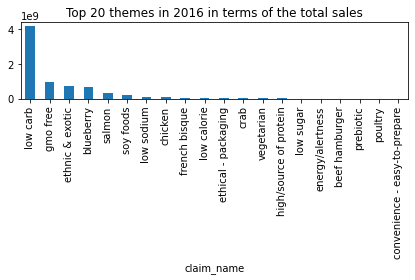

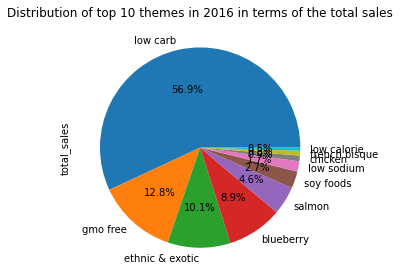

In [56]:
g = pd.DataFrame(merged_df_final[merged_df_final['year_new']==2016].groupby(['claim_name']).agg(total_sales=('sales_dollars_value','sum')))
g.sort_values(by='total_sales',ascending=False,inplace=True)
g['total_sales'][:20].plot.bar()
print('Total sales in 2016 = ',g['total_sales'].sum())
plt.title('Top 20 themes in 2016 in terms of the total sales')
plt.show()
g['total_sales'][:10].plot.pie(autopct='%1.1f%%')
plt.title('Distribution of top 10 themes in 2016 in terms of the total sales')
plt.show()

Total sales in 2017 =  8808140832


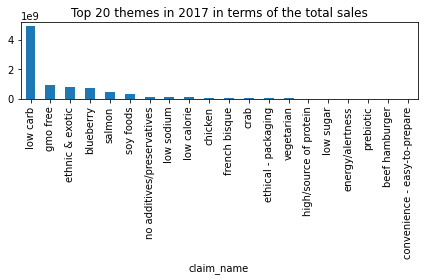

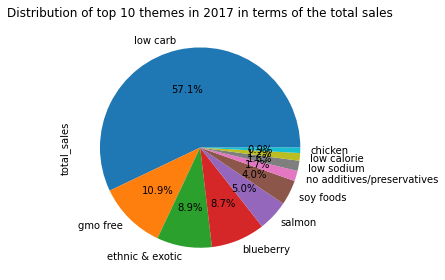

In [57]:
g = pd.DataFrame(merged_df_final[merged_df_final['year_new']==2017].groupby(['claim_name']).agg(total_sales=('sales_dollars_value','sum')))
g.sort_values(by='total_sales',ascending=False,inplace=True)
print('Total sales in 2017 = ',g['total_sales'].sum())
g['total_sales'][:20].plot.bar()
plt.title('Top 20 themes in 2017 in terms of the total sales')
plt.show()
g['total_sales'][:10].plot.pie(autopct='%1.1f%%')
plt.title('Distribution of top 10 themes in 2017 in terms of the total sales')
plt.show()

Total sales in 2018 =  29542880825


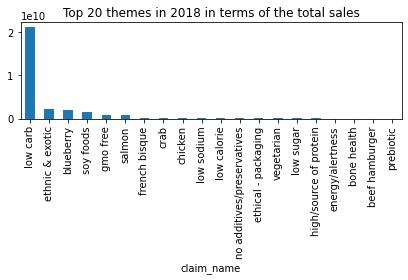

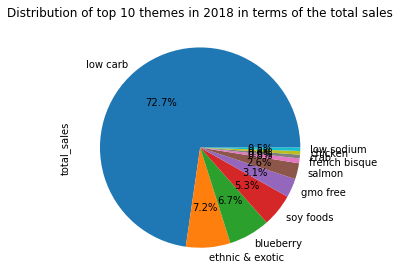

In [58]:
g = pd.DataFrame(merged_df_final[merged_df_final['year_new']==2018].groupby(['claim_name']).agg(total_sales=('sales_dollars_value','sum')))
g.sort_values(by='total_sales',ascending=False,inplace=True)
print('Total sales in 2018 = ',g['total_sales'].sum())
g['total_sales'][:20].plot.bar()
plt.title('Top 20 themes in 2018 in terms of the total sales')
plt.show()
g['total_sales'][:10].plot.pie(autopct='%1.1f%%')
plt.title('Distribution of top 10 themes in 2018 in terms of the total sales')
plt.show()

Total sales in 2019 =  22093708470


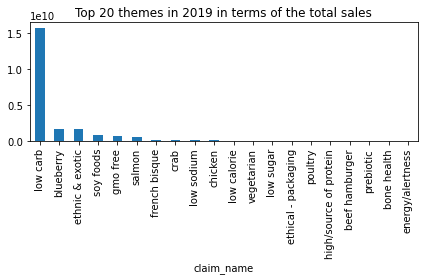

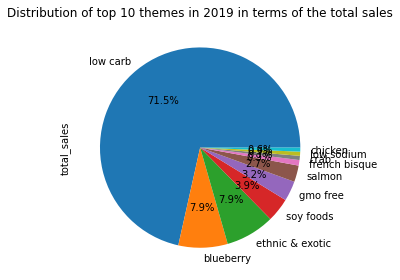

In [59]:
g = pd.DataFrame(merged_df_final[merged_df_final['year_new']==2019].groupby(['claim_name']).agg(total_sales=('sales_dollars_value','sum')))
g.sort_values(by='total_sales',ascending=False,inplace=True)
print('Total sales in 2019 = ',g['total_sales'].sum())
g['total_sales'][:20].plot.bar()
plt.title('Top 20 themes in 2019 in terms of the total sales')
plt.show()
g['total_sales'][:10].plot.pie(autopct='%1.1f%%')
plt.title('Distribution of top 10 themes in 2019 in terms of the total sales')
plt.show()

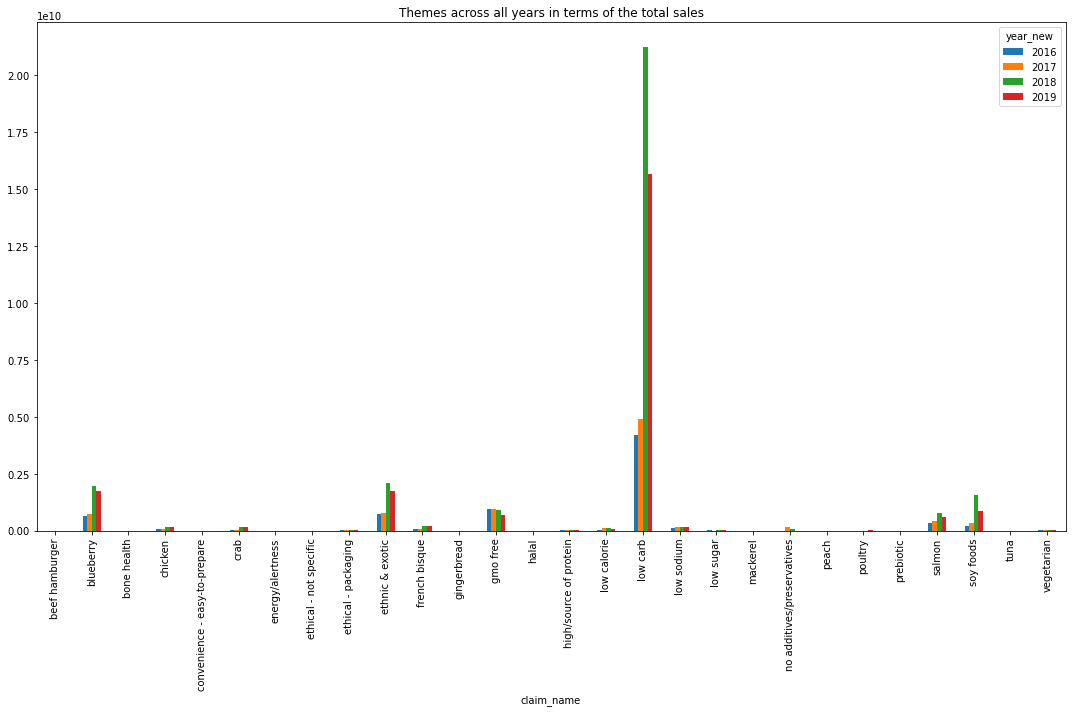

In [60]:
g = pd.DataFrame(merged_df_final.groupby(['claim_name','year_new']).agg(total_sales=('sales_dollars_value','sum')))
g.sort_values(by='total_sales',ascending=False,inplace=True)
g['total_sales'].unstack().plot(kind='bar', figsize=(15, 10))
plt.title('Themes across all years in terms of the total sales')
plt.show()

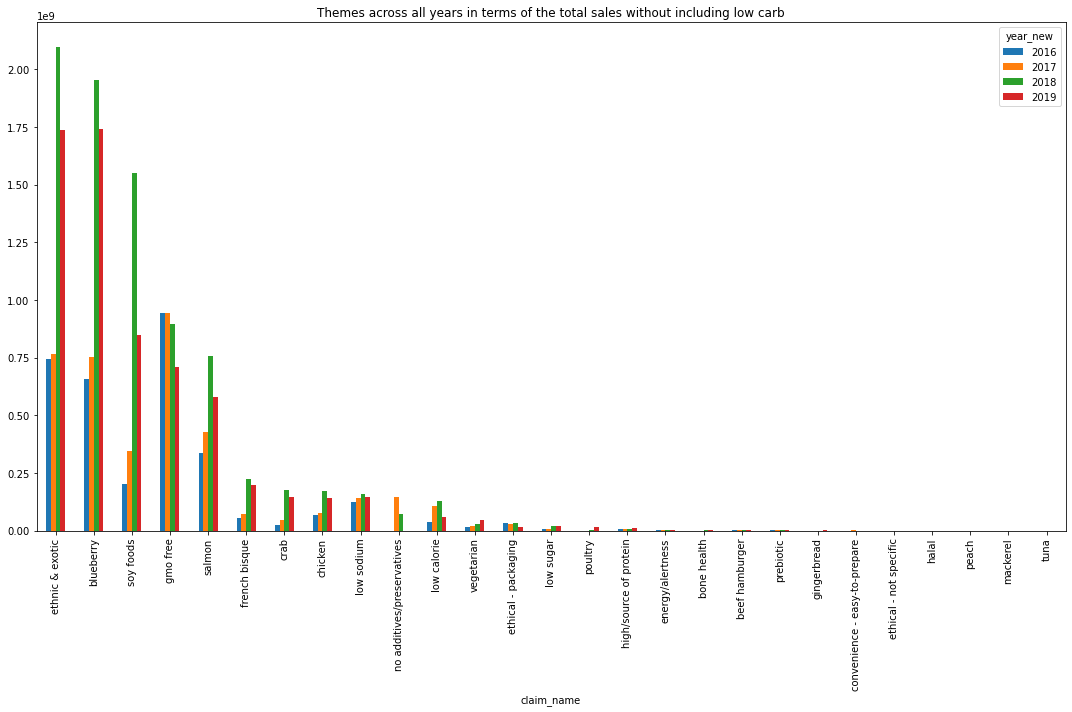

In [61]:
g = pd.DataFrame(merged_df_final.groupby(['claim_name','year_new']).agg(total_sales=('sales_dollars_value','sum')))
g.sort_values(by='total_sales',ascending=False,inplace=True)
g['total_sales'][4:].unstack().plot(kind='bar', figsize=(15, 10))
plt.title('Themes across all years in terms of the total sales without including low carb')
plt.show()

- The above plots show the top themes in terms of total sales achieved for years 2016 to 2019. 
- As can be seen from the pie charts, low carb sales have risen significantly from about 56% in 2016-17 to about 72% in 2018-19
- Seeing the rise in sales of low carb, it can be said it has a high business opportunity.
- Alongwith low carb, there are other themes too whose sales have increased from 2016 and may prove to have high business opportunity in the near future. These are ethnic & exotic, blueberry, soy foods, salmon, french bisque, crab, chicken, vegetarian.

### ●	What are the controllable factors which client could leverage to increase sales across themes?

### ●	How to achieve a 5% increase in sales overall?

In [62]:
df=merged_df_final[merged_df_final['vendor']=='A']
vendorA_themes = df['claim_name'].unique()
vendorA_themes

array(['low carb', 'no additives/preservatives', 'low sodium',
       'ethnic & exotic', 'gmo free', 'french bisque', 'salmon',
       'blueberry', 'crab', 'soy foods', 'high/source of protein',
       'gingerbread', 'chicken', 'beef hamburger', 'poultry',
       'vegetarian', 'ethical - packaging', 'low sugar', 'tuna'],
      dtype=object)

In [63]:
data=merged_df_final
print('**Unexplored Themes by our client with the total sales achieved in 4 years**')
for theme in data['claim_name'].unique():
    if theme not in vendorA_themes:
        data=merged_df_final[(merged_df_final['claim_name']==theme)]
        print('Theme = {}'.format(theme))
        data = data.groupby('vendor')['sales_dollars_value'].agg(Total_sales = ('sales_dollars_value', 'sum'))
        print(data)
        print('-'*70)

**Unexplored Themes by our client with the total sales achieved in 4 years**
Theme = energy/alertness
               Total_sales
vendor                    
H                   391011
Others             7432378
Private Label       457620
----------------------------------------------------------------------
Theme = prebiotic
        Total_sales
vendor             
Others      5552748
----------------------------------------------------------------------
Theme = mackerel
        Total_sales
vendor             
Others         5950
----------------------------------------------------------------------
Theme = low calorie
        Total_sales
vendor             
Others    333608906
----------------------------------------------------------------------
Theme = convenience - easy-to-prepare
        Total_sales
vendor             
Others      1562930
----------------------------------------------------------------------
Theme = peach
        Total_sales
vendor             
Others        20068
-

- As we can see from the data above, there are some themes with significant sales that are yet to be explored by our cient. These can be taken into account and used to increase the overall sales. These themes are low-calorie, energy/alertness, prebiotic,bone health, convenience - easy-to-prepare

## 3. Feature Engineering

### 3.1. Read Train and Test Data

In [64]:
train_X = load_dataset(context, 'train/sales/features')
train_y = load_dataset(context, 'train/sales/target')
print(train_X.shape, train_y.shape)

test_X = load_dataset(context, 'test/sales/features')
test_y = load_dataset(context, 'test/sales/target')
print(test_X.shape, test_y.shape)

(4429056, 14) (4429056, 1)
(1107264, 14) (1107264, 1)


In [65]:
train_X.drop(['claim_id'],axis=1,inplace=True)
test_X.drop(['claim_id'],axis=1,inplace=True)

### 3.2. Feature Engineering Pipelines

In [66]:
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

In [67]:
cat_columns

Index(['platform', 'claim_name', 'vendor', 'month'], dtype='object')

In [68]:
num_columns

Index(['search_volume', 'week_number', 'year_new', 'total_post', 'product_id',
       'day', 'quarter', 'weight_of_product'],
      dtype='object')

#### Dealing with the outliers.

In [69]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
sales_processed_df = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(4429056, 13)
(4429056, 13)


#### Encoding

In [70]:
tgt_enc_simple_impt = Pipeline([
    ('target_encoding', TargetEncoder(return_df=False)),
    ('simple_impute', SimpleImputer(strategy='most_frequent')),
])


# NOTE: the list of transformations here are not sequential but weighted 
# (if multiple transforms are specified for a particular column)
# for sequential transforms use a pipeline as shown above.
features_transformer = ColumnTransformer([
    
    ## categorical columns
    ('tgt_enc', TargetEncoder(return_df=False),
     list(set(cat_columns) - set([]))),
    
    # NOTE: if the same column gets repeated, then they are weighed in the final output
    # If we want a sequence of operations, then we use a pipeline but that doesen't YET support
    # get_feature_names. 
    ('tgt_enc_sim_impt', tgt_enc_simple_impt,[]),
        
    ## numeric columns
    ('med_enc', SimpleImputer(strategy='median'), num_columns),
    
])

In [71]:
sample_X = train_X.sample(frac=0.1, random_state=context.random_seed)
sample_y = train_y.loc[sample_X.index]

sample_train_X = get_dataframe(
    features_transformer.fit_transform(sample_X, sample_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

# nothing to do for target
sample_train_y = sample_y

In [72]:
sample_train_X

,platform,vendor,month,claim_name,search_volume,week_number,year_new,total_post,product_id,day,quarter,weight_of_product
0,3.874025e+08,8.746096e+03,4.482682e+08,4.120888e+05,2678.0,3.0,2018.0,52.0,12900.0,20.0,1.0,11.89
1,3.874025e+08,8.746096e+03,4.525481e+08,5.645956e+08,7248.0,38.0,2016.0,205.0,21607.0,24.0,3.0,0.37
2,3.874025e+08,3.222522e+04,4.448806e+08,5.645956e+08,6823.0,16.0,2019.0,178.0,32802.0,20.0,2.0,23.96
3,5.399443e+08,4.792594e+09,4.482682e+08,5.645956e+08,385.0,3.0,2019.0,2447.0,12093.0,19.0,1.0,0.49
4,4.571733e+08,8.746096e+03,4.464253e+08,5.645956e+08,1300.0,7.0,2018.0,322.0,22199.0,17.0,1.0,13.70
...,...,...,...,...,...,...,...,...,...,...,...,...
442901,4.571733e+08,8.746096e+03,4.492528e+08,1.781589e+08,716.0,12.0,2018.0,399.0,27623.0,24.0,1.0,3.53
442902,4.571733e+08,8.746096e+03,4.525481e+08,5.645956e+08,623.0,36.0,2019.0,180.0,42221.0,7.0,3.0,0.11
442903,3.874025e+08,8.746096e+03,4.482682e+08,5.645956e+08,10459.0,1.0,2019.0,673.0,35301.0,5.0,1.0,5.97
442904,3.874025e+08,2.642489e+04,4.703666e+08,3.080240e+08,881.0,27.0,2017.0,21.0,12529.0,8.0,3.0,10.99


In [73]:
sample_y

,sales_dollars_value
741428,988
2112861,6507
3825068,15457
4803384,6004276125
3396464,212
...,...
4560467,317
2658744,2396
224950,3343
2437417,2648


In [74]:
train_X = get_dataframe(
    features_transformer.fit_transform(train_X, train_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

#### 3.3.1. Univariate

In [75]:
out = eda.get_density_plots(train_X, cols=['platform','vendor','month','quarter'])
out

:DynamicMap   [col]
   :Layout
      .Overlay.I :Overlay
         .Histogram.I    :Histogram   [x]   (Frequency)
         .Distribution.I :Distribution   [platform]   (Density)
      .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [76]:
reports.create_report({'univariate': out}, name='feature_analysis_univariate')

In [77]:
reports.feature_analysis(train_X,'./feature_analysis_report.html')

p-value may not be accurate for N > 5000.


#### 3.3.2. Bivariate - mutual interactions

In [78]:
out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,quarter,week_number,0.964498,0.964498
1,platform,search_volume,-0.620127,0.620127


## 4. Modelling

### 4.1 Linear Regression

In [79]:
cols = list(train_X.columns)
vif = eda.calc_vif(train_X)
while max(vif.VIF) > 5:
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(train_X[cols])

In [80]:
vif

,variables,VIF
0,platform,1.913910
1,vendor,1.194744
2,month,1.131585
3,claim_name,1.246346
4,search_volume,1.734777
5,year_new,0.001179
6,total_post,1.069512
7,product_id,1.220610
8,day,1.003128
9,quarter,1.130509


In [81]:
reg_vars = vif.query('VIF < 5').variables
reg_vars = list(reg_vars)

In [82]:
len(reg_vars)

11

In [83]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

In [84]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(train_X, train_y.values.ravel())


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f2d752871f0>,
                                     kw_args={'cols2keep': ['platform',
                                                            'vendor', 'month',
                                                            'claim_name',
                                                            'search_volume',
                                                            'year_new',
                                                            'total_post',
                                                            'product_id', 'day',
                                                            'quarter',
                                                            'weight_of_product']})),
                ('estimator', SKLStatsmodelOLS())])

In [85]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                 1.926e+06
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        08:56:01   Log-Likelihood:            -9.6125e+07
No. Observations:             4429056   AIC:                         1.923e+08
Df Residuals:                 4429044   BIC:                         1.923e+08
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept          1.707e+10    7.6e+08     22.449      0.000    1.56e+10    1.86e+10
platform             -0.0566      0.007     -8.458      0.000      -0.070      -0.043
vendor                0.9908      0.000   4135.375      0.000       0.990       0.991
month                 0.2004      0.052      3.860      0.000       0.099       0.302
claim_name            0.8341      0.002    512.003      0.000       0.831       0.837
search_volume     -1437.9012     99.027    -14.520      0.000   -1631.991   -1243.811
year_new          -8.631e+06   3.79e+05    -22.791      0.000   -9.37e+06   -7.89e+06
total_post          958.9442    565.829      1.695      0.090    -150.061    2067.949
product_id        -1772.6314     25.195    -70.358      0.000   -1822.012   -1723.251
day               -1.192e+04   3.49e+04     -0.342      0.732   -8.02e+04    5.64e+04
quarter           -2.308e+06   3.16e+05     -7.304      0.000   -2.93e+06   -1.69e+06
weight_of_product -5.593e+06   3.84e+04   -145.624      0.000   -5.67e+06   -5.52e+06
==============================================================================
Omnibus:                  3501060.371   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         95382250.464
Skew:                          -3.661   Prob(JB):                         0.00
Kurtosis:                      24.523   Cond. No.                     3.71e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
reg_vars.remove('day')

In [87]:
reg_ppln_ols.fit(train_X, train_y.values.ravel())

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f2d752871f0>,
                                     kw_args={'cols2keep': ['platform',
                                                            'vendor', 'month',
                                                            'claim_name',
                                                            'search_volume',
                                                            'year_new',
                                                            'total_post',
                                                            'product_id',
                                                            'quarter',
                                                            'weight_of_product']})),
                ('estimator', SKLStatsmodelOLS())])

In [88]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                 2.119e+06
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        08:56:56   Log-Likelihood:            -9.6125e+07
No. Observations:             4429056   AIC:                         1.923e+08
Df Residuals:                 4429045   BIC:                         1.923e+08
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept          1.707e+10    7.6e+08     22.447      0.000    1.56e+10    1.86e+10
platform             -0.0566      0.007     -8.455      0.000      -0.070      -0.043
vendor                0.9908      0.000   4135.377      0.000       0.990       0.991
month                 0.1995      0.052      3.847      0.000       0.098       0.301
claim_name            0.8341      0.002    512.003      0.000       0.831       0.837
search_volume     -1437.5618     99.022    -14.518      0.000   -1631.642   -1243.481
year_new           -8.63e+06   3.79e+05    -22.789      0.000   -9.37e+06   -7.89e+06
total_post          958.7151    565.829      1.694      0.090    -150.289    2067.719
product_id        -1772.6566     25.194    -70.359      0.000   -1822.037   -1723.276
quarter           -2.307e+06   3.16e+05     -7.301      0.000   -2.93e+06   -1.69e+06
weight_of_product -5.593e+06   3.84e+04   -145.624      0.000   -5.67e+06   -5.52e+06
==============================================================================
Omnibus:                  3501060.920   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         95382317.640
Skew:                          -3.661   Prob(JB):                         0.00
Kurtosis:                      24.523   Cond. No.                     3.71e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [89]:
reg_vars.remove('total_post')
reg_ppln_ols.fit(train_X, train_y.values.ravel())

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f2d752871f0>,
                                     kw_args={'cols2keep': ['platform',
                                                            'vendor', 'month',
                                                            'claim_name',
                                                            'search_volume',
                                                            'year_new',
                                                            'product_id',
                                                            'quarter',
                                                            'weight_of_product']})),
                ('estimator', SKLStatsmodelOLS())])

In [90]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                 2.354e+06
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        08:57:25   Log-Likelihood:            -9.6125e+07
No. Observations:             4429056   AIC:                         1.923e+08
Df Residuals:                 4429046   BIC:                         1.923e+08
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept          1.703e+10    7.6e+08     22.408      0.000    1.55e+10    1.85e+10
platform             -0.0555      0.007     -8.337      0.000      -0.069      -0.042
vendor                0.9908      0.000   4135.380      0.000       0.990       0.991
month                 0.2048      0.052      3.957      0.000       0.103       0.306
claim_name            0.8345      0.002    518.876      0.000       0.831       0.838
search_volume     -1422.5869     98.627    -14.424      0.000   -1615.893   -1229.281
year_new          -8.613e+06   3.79e+05    -22.753      0.000   -9.36e+06   -7.87e+06
product_id        -1772.8434     25.194    -70.367      0.000   -1822.223   -1723.464
quarter           -2.349e+06   3.15e+05     -7.458      0.000   -2.97e+06   -1.73e+06
weight_of_product -5.593e+06   3.84e+04   -145.622      0.000   -5.67e+06   -5.52e+06
==============================================================================
Omnibus:                  3501061.622   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         95382223.964
Skew:                          -3.661   Prob(JB):                         0.00
Kurtosis:                      24.523   Cond. No.                     3.71e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [91]:
reg_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('Linear Regression', SKLStatsmodelOLS())
])

test_X = get_dataframe(
    features_transformer.transform(test_X), 
    get_feature_names_from_column_transformer(features_transformer)
)
test_X = test_X[reg_vars]

In [ ]:
reg_linear_report = RegressionReport(model=reg_ppln, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='regression_linear_model_report')

divide by zero encountered in true_divide
2022-07-01 08:57:59 - WARNING - tigerml.model_eval.plotters.interpretation::get_errorbucket_profiles::847 - Residual Analysis: Ignoring 13991 observations in train data for error analysis where y=0
2022-07-01 08:58:01 - WARNING - tigerml.model_eval.plotters.interpretation::get_errorbucket_profiles::864 - Residual Analysis: Ignoring 3482 observations in test data for error analysis where y=0
